In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import seaborn as sns
from scipy.optimize import linear_sum_assignment
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score
from sklearn.decomposition import PCA
from scipy.stats import mode


Load Dataset

In [2]:
file_path = './Dataset/Dataset1.csv'
df = pd.read_csv(file_path, low_memory=False)

In [3]:
df =pd.read_csv("./Dataset/Dataset1.csv")
df_orig = df.copy()
df = df.drop(columns=['App', 'Date'])
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df)

In [ ]:
df =pd.read_csv("./Dataset/ModifiedDataset1.csv")
df_orig = df.copy()
df = df.drop(columns=['App'])
scaler = StandardScaler()
df_numeric = df.select_dtypes(include=[np.number])  # Keep only numeric columns
X_scaled = scaler.fit_transform(df_numeric)


In [5]:
class KMeanHelpers:
    def __init__(self, data, k):
        self.data = data
        self.k = k

    # method to calculate the variation of clusters
    # high clustered = low WCSS
    # high variation = high WCSS
    def calculate_wcss(self, centroids, cluster_assignments):
        wcss = 0
        for i, centroid in enumerate(centroids):
            points_in_cluster = self.data[cluster_assignments == i]
            wcss += np.sum((points_in_cluster - centroid) ** 2)
        return wcss

    # method to see the nearest k from the data point
    def euclidean_distance(self, p1, p2):
        return np.sqrt(np.sum((p1 - p2) ** 2))

    # method to compute K mean
    def compute(self, max_iters=100):
        np.random.seed(42) # set seed for random.choice for consistency
        centroids = self.data[np.random.choice(self.data.shape[0], self.k, replace=False)] # set initial centroids randomly
        cluster_assignments = np.zeros(self.data.shape[0])

        #iteratively calculate distance of data point to centroids
        for _ in range(max_iters):
            for i, point in enumerate(self.data):
                distances = [self.euclidean_distance(point, centroid) for centroid in centroids]
                cluster_assignments[i] = np.argmin(distances) # the smallest distance will be its cluster

            # set new centroids by the mean of each clusters
            new_centroids = np.array([self.data[cluster_assignments == i].mean(axis=0)
                                       if np.any(cluster_assignments == i) else centroids[i]
                                       for i in range(self.k)])
            # stop the iteration if centroids is the same as previous
            if np.all(centroids == new_centroids):
                break
            centroids = new_centroids # continue iteration if not

        return centroids, cluster_assignments

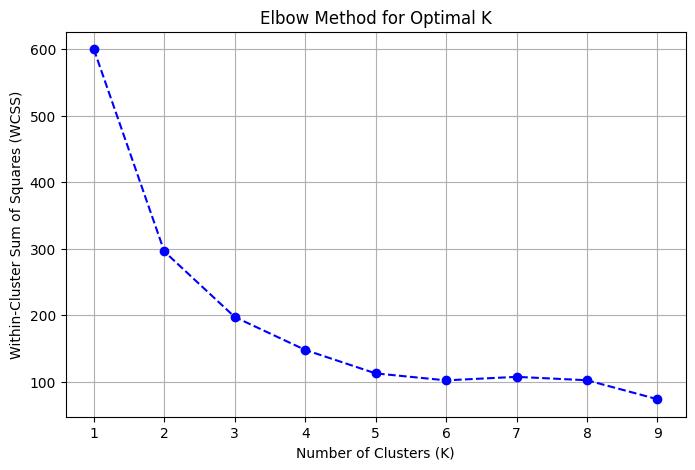

In [6]:
# set candidate optimal k
k_values = range(1, 10)
wcss_values = []

# calculate WCSS value of each k
for k in k_values:
    km = KMeanHelpers(X_scaled, k)
    centroids, cluster_assignments = km.compute()
    wcss = km.calculate_wcss(centroids, cluster_assignments)
    wcss_values.append(wcss)

# create elbow plot to see optimal k
plt.figure(figsize=(8, 5))
plt.plot(k_values, wcss_values, marker='o', linestyle='--', color='b')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Within-Cluster Sum of Squares (WCSS)')
plt.title('Elbow Method for Optimal K')
plt.xticks(k_values)
plt.grid()
plt.show()

Using the elbow method, we can better see the biggest change in the
graph. We calculate this by finding the smallest angle. The biggest change is from 1 to 2. Therefore, we will choose 2 as our K value.

In [7]:
k = 2
km = KMeanHelpers(X_scaled, k)
centroids, cluster_assignments = km.compute()

df_orig["Cluster"] = cluster_assignments.astype(int)

print(df_orig)

           Date        App  Usage (minutes)  Notifications  Times Opened  \
0    2024-08-07  Instagram               81             24            57   
1    2024-08-08  Instagram               90             30            53   
2    2024-08-26  Instagram              112             33            17   
3    2024-08-22  Instagram               82             11            38   
4    2024-08-12  Instagram               59             47            16   
..          ...        ...              ...            ...           ...   
195  2024-08-10   LinkedIn               22             12             5   
196  2024-08-23   LinkedIn                5              7             1   
197  2024-08-18   LinkedIn               19              2             5   
198  2024-08-26   LinkedIn               21             14             1   
199  2024-08-02   LinkedIn               13              4             1   

     Cluster  
0          1  
1          1  
2          1  
3          1  
4          0

Comparing to our old implementation where we used Usage column, now we manually created true label for clustering, categorizing based on leisure and productivity apps

In [8]:
# Define manual labels based on known app categories
high_engmnt = ["Instagram", "WhatsApp"]
low_engmnt = ["Safari", "8 Ball Pool"]

# Map app names to labels
df_orig["True_Label"] = df_orig["App"].apply(lambda x: 0 if x in high_engmnt else 1)


y_true = df_orig["True_Label"].astype(int).values  # True labels
y_pred = df_orig["Cluster"].astype(int).values  # Cluster assignments from K-Means

In [10]:
# Function to map clusters to manually defined labels
def best_cluster_mapping(y_true, y_pred):
    labels = np.unique(y_true)
    clusters = np.unique(y_pred)
    cost_matrix = np.zeros((len(labels), len(clusters)))

    for i, label in enumerate(labels):
        for j, cluster in enumerate(clusters):
            cost_matrix[i, j] = -np.sum((y_true == label) & (y_pred == cluster))

    row_ind, col_ind = linear_sum_assignment(cost_matrix)
    mapping = {clusters[col]: labels[row] for row, col in zip(row_ind, col_ind)}

    return np.array([mapping[cluster] for cluster in y_pred])

# Apply mapping to adjust predicted clusters
y_pred_mapped = best_cluster_mapping(df_orig["True_Label"].values, df_orig["Cluster"].values)

# Assign human-readable labels
df_orig["Predicted_Label"] = y_pred_mapped
df_orig["Predicted_Label"] = df_orig["Predicted_Label"].map({0: "High", 1: "Low"})

In [11]:
# Compute classification metrics
accuracy = accuracy_score(y_true, y_pred_mapped)
precision = precision_score(y_true, y_pred_mapped, average='weighted')
recall = recall_score(y_true, y_pred_mapped, average='weighted')
f1 = f1_score(y_true, y_pred_mapped, average='weighted')

print(f"\nAccuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")


Accuracy: 0.9350
Precision: 0.9368
Recall: 0.9350
F1 Score: 0.9356


In [12]:
# Initialize PCA with 2 components (reduce data to 2 dimensions)
pca = PCA(n_components=2)

# Fit PCA directly on scaled data
pca_result = pca.fit_transform(X_scaled)

# Transform the cluster centroids using the same PCA transformation
# This ensures centroids are in the same 2D space as the data
centroids_pca = pca.transform(centroids)

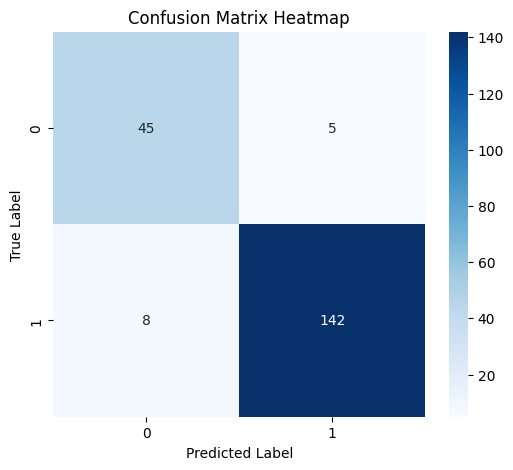

In [13]:
# Confusion Matrix Heatmap (Corrected Labels)
conf_matrix = confusion_matrix(y_true, y_pred_mapped)
labels = sorted(np.unique(y_true))  # Ensure proper label alignment

plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix Heatmap")
plt.show()

In [14]:
class KMeanVisualizer:
    def __init__(self, data, k):
        self.data = data
        self.k = k

    def euclidean_distance(self, p1, p2):
        return np.sqrt(np.sum((p1 - p2) ** 2))

    def compute_and_visualize(self, max_iters=10):
        np.random.seed(42)
        centroids = self.data[np.random.choice(self.data.shape[0], self.k, replace=False)]
        cluster_assignments = np.zeros(self.data.shape[0])

        # Precompute PCA for 2D visualization
        pca = PCA(n_components=2)
        pca_2d = pca.fit_transform(self.data)

        for itr in range(max_iters):
            # Assign points to nearest centroid
            for i, point in enumerate(self.data):
                distances = [self.euclidean_distance(point, centroid) for centroid in centroids]
                cluster_assignments[i] = np.argmin(distances)

            # Plot current iteration
            self._plot_iteration(pca_2d, cluster_assignments, centroids, pca, itr)

            # Recalculate centroids
            new_centroids = np.array([
                self.data[cluster_assignments == i].mean(axis=0)
                if np.any(cluster_assignments == i) else centroids[i]
                for i in range(self.k)
            ])

            if np.allclose(centroids, new_centroids):
                print(f"Converged at iteration {itr}")
                break

            centroids = new_centroids

        return centroids, cluster_assignments.astype(int), itr

    def _plot_iteration(self, pca_2d, assignments, centroids, pca, iteration):
        df_vis = pd.DataFrame(pca_2d, columns=["PCA1", "PCA2"])
        df_vis["Cluster"] = assignments.astype(int)

        if self.k == 2:
            # Label and color for 2-cluster (High/Low)
            cluster_map = {0: "Low", 1: "High"}
            df_vis["Engagement"] = df_vis["Cluster"].map(cluster_map)
            palette = {"High": "red", "Low": "blue"}
            hue = "Engagement"
        else:
            hue = "Cluster"
            palette = "tab10"

        plt.figure(figsize=(8, 6))
        sns.scatterplot(
            data=df_vis,
            x="PCA1", y="PCA2",
            hue=hue,
            palette=palette,
            alpha=0.7,
            edgecolor="k",
            s=70
        )

        # Transform centroids into 2D using the same PCA
        centroids_2d = pca.transform(centroids)
        plt.scatter(
            centroids_2d[:, 0], centroids_2d[:, 1],
            marker='*', s=180, c='black', edgecolor='white',
            linewidth=1.2, label='Centroids'
        )

        plt.title(f"K-Means Iteration {iteration}")
        plt.xlabel("Principal Component 1")
        plt.ylabel("Principal Component 2")
        plt.legend(title="App Category" if self.k == 2 else "Cluster")
        plt.grid(True, linestyle="--", alpha=0.4)
        plt.tight_layout()
        plt.show()


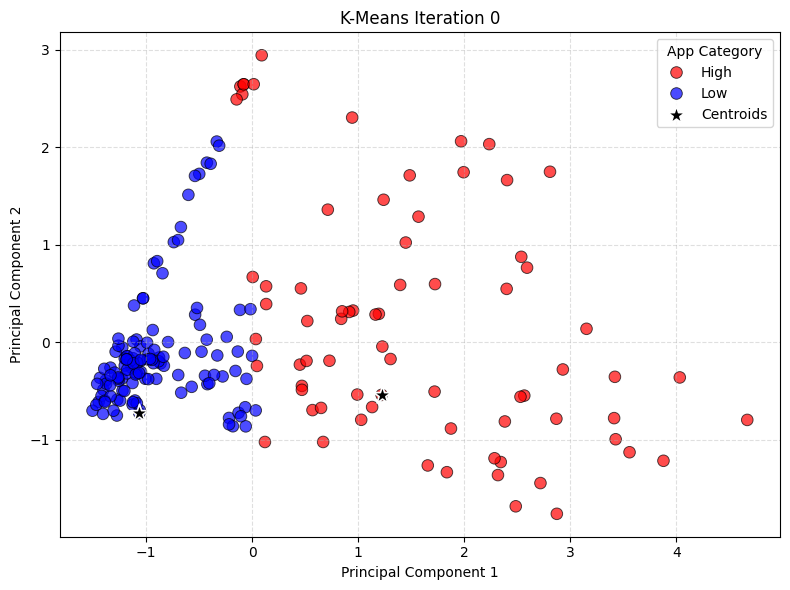

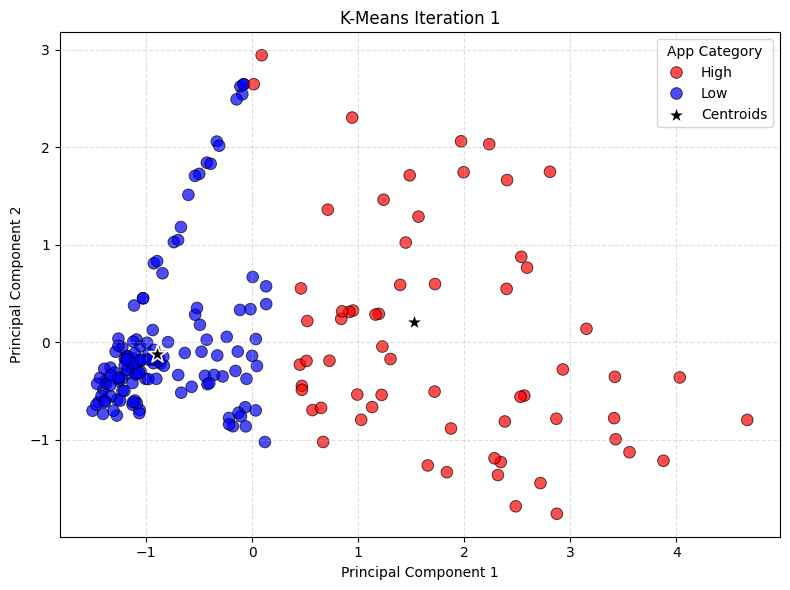

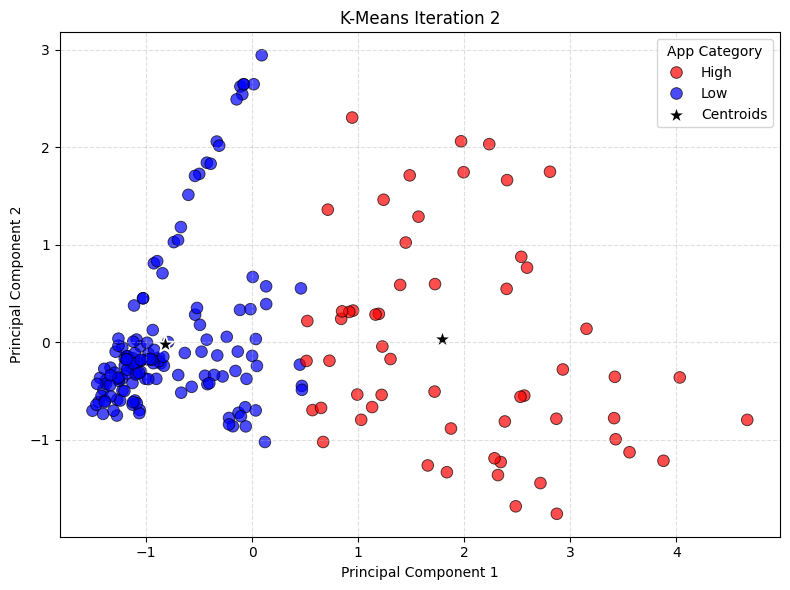

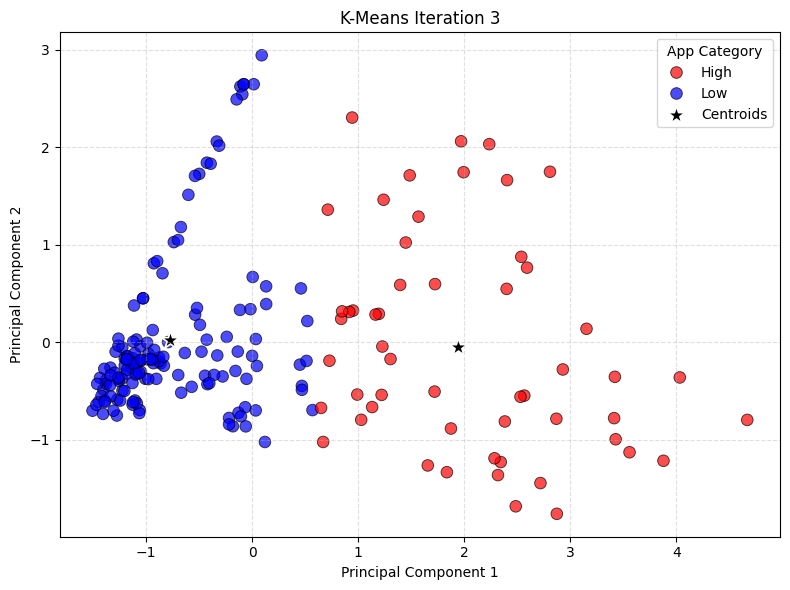

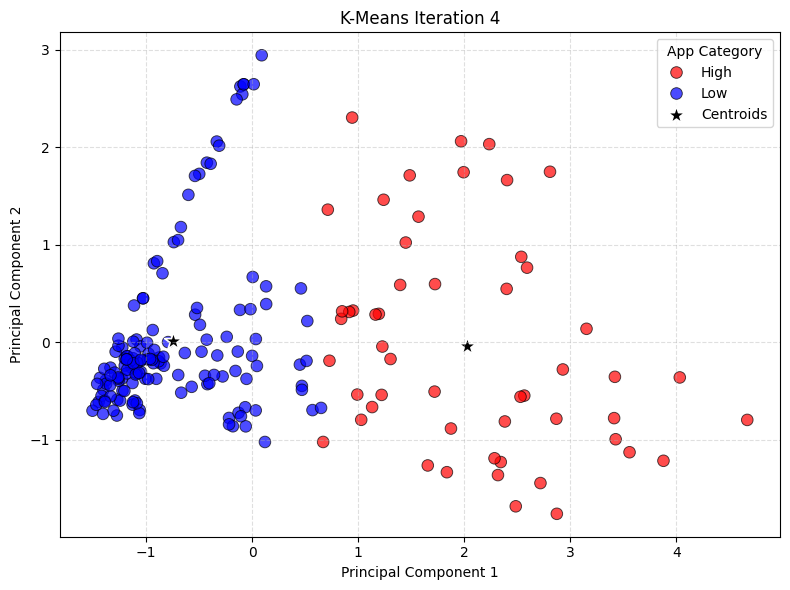

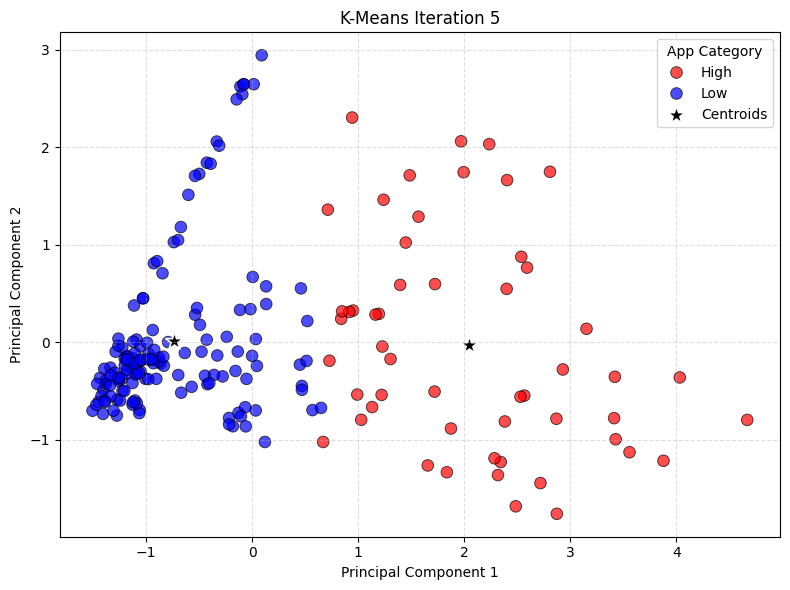

Converged at iteration 5


In [15]:
k = 2
kmeans_vis = KMeanVisualizer(X_scaled, k)
centroids, assignments, final_itr = kmeans_vis.compute_and_visualize(max_iters=10)


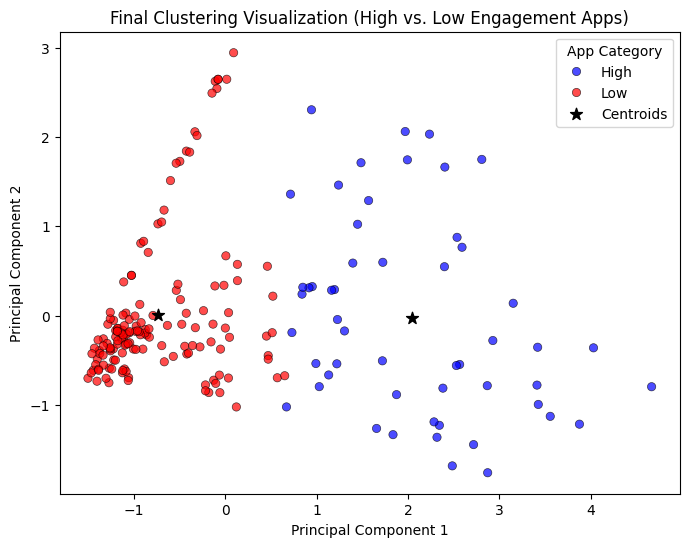

In [16]:
# Scatter Plot of Clusters (Using PCA for Dimensionality Reduction)
pca = PCA(n_components=2)
df_pca = pd.DataFrame(X_scaled, columns=["Usage (minutes)", "Notifications", "Times Opened"])
pca_result = pca.fit_transform(df_pca)

df_orig["PCA1"] = pca_result[:, 0]
df_orig["PCA2"] = pca_result[:, 1]

plt.figure(figsize=(8, 6))
sns.scatterplot(
    x="PCA1", y="PCA2",
    hue=df_orig["Predicted_Label"],
    palette={"High": "blue", "Low": "red"},
    data=df_orig, alpha=0.7, edgecolor="k"
)
plt.title("Final Clustering Visualization (High vs. Low Engagement Apps)")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.scatter(centroids_pca[:, 0], centroids_pca[:, 1], marker='*', s=80, c='black', label='Centroids')
plt.legend(title="App Category")
plt.show()
